In [1]:
import os
import sys

In [2]:
sys.path.append('../lib')
sys.path.append('../lib/sigkernel')

In [3]:
import cov_independence_test
import hsic_independence_test
import gen_processes

In [4]:
from importlib import reload

In [5]:
reload(cov_independence_test);
reload(hsic_independence_test);
reload(gen_processes);

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.ar_model as ar
import torch
torch.set_default_dtype(torch.double)
import sigkernel_scale

In [7]:
import pprint
pp = pprint.PrettyPrinter(indent = 4)

In [8]:
import scipy.stats as stats

In [9]:
from tqdm import tqdm

In [10]:
from itertools import product

In [11]:
import matplotlib.pyplot as plt

In [12]:
from scipy.optimize import brentq

In [13]:
rng = np.random.default_rng(1234)

In [14]:
BIG_RESULT_MEMORY_PLACE = []

In [175]:
N_TIMESTEPS = 1800
SIG_KERNEL_SAMPLES_NO = 300
M_RUNS = 50
EXTINCTION_RATES = [0.9]
#EXTINCTION_RATES = [1]
PROC_DIV = 32
RBF_SIGMA = 4
A=0.

In [81]:
assert N_TIMESTEPS % SIG_KERNEL_SAMPLES_NO == 0, 'Cannot reshape such array properly'

In [108]:
processes = gen_processes.gen_ar_iid_samples_extinct_gaussian_burn_in(N_TIMESTEPS+1, M_RUNS, a = 0.2, extinction_rate = 1)

In [17]:
def psi(x, M=4, a=1):
    x = x ** 2

    if x <= M:
        return x

    return M + M ** (1 + a) * (M ** (-a) - x ** (-a)) / a

In [18]:
def normalize_paths_linear_static_kernel(paths, kernel):
    path_norm = torch.zeros_like(paths)
    for i in range(paths.shape[0]):
        kernel_xx = kernel.compute_kernel(paths[i:i+1, :, :], paths[i:i+1, :, :])
       # print(kernel_xx)
        target = psi(np.sqrt(kernel_xx.item()))
        f = lambda lam: target - kernel.compute_kernel(lam*paths[i:i+1, :, :], lam*paths[i:i+1, :, :]).item()
        lam = min(max(brentq(f, 0., 1.1, xtol=1e-300, maxiter = 1000), 0), 1)
        print(lam)
        path_norm[i:i+1, :, :] = lam*paths[i:i+1, :, :]
    return path_norm

In [19]:
def get_postscale_for_batch(paths, kernel):
    postscale = torch.zeros(paths.shape[0])
    for i in range(paths.shape[0]):
        kernel_xx = kernel.compute_kernel(paths[i:i+1, :, :], paths[i:i+1, :, :])
        target = psi(np.sqrt(kernel_xx.item()))
        f = lambda lam: target - kernel.compute_kernel(paths[i:i+1, :, :], paths[i:i+1, :, :], torch.tensor([lam]), torch.tensor([lam])).item()
        lam = min(max(brentq(f, 0., 1.1, xtol=1e-300, maxiter = 1000), 0), 1)
        # print(lam)
        postscale[i] = lam
    return postscale

In [109]:
X_raw = processes[:, :30, 0]
X_lead_lag_chopped = torch.stack((X_raw[:, 1:], X_raw[:, :-1]), axis = 2)

In [110]:
X_lead_lag_chopped.std()

tensor(1.2504)

In [144]:
postscale = get_postscale_for_batch(X_lead_lag_chopped, sigkernel_scale.SigKernel(sigkernel_scale.LinearKernel(), 3));
print(postscale)

tensor([0.4820, 0.3559, 0.6982, 0.3614, 0.8294, 0.7254, 0.9711, 0.3764, 0.3203,
        0.5471, 0.5262, 0.3960, 0.5318, 0.3824, 0.8511, 0.4225, 0.6285, 0.4533,
        0.4820, 0.8192, 0.2775, 0.7109, 0.6600, 0.9661, 0.7371, 0.6261, 0.2999,
        0.9524, 0.8237, 0.4022, 0.9941, 1.0000, 0.4712, 0.6251, 0.3371, 0.5749,
        0.8945, 0.2335, 0.6072, 0.3233, 0.4476, 0.5790, 0.9982, 0.4193, 0.3681,
        0.4373, 0.7110, 0.4293, 0.3426, 0.5575, 0.6258, 0.4809, 0.6851, 0.6654,
        0.7667, 0.3376, 0.7984, 0.5324, 0.4680, 0.5932, 0.4527, 0.7242, 0.5155,
        0.8464, 0.4133, 0.3532, 0.6594, 0.6676, 0.3988, 0.8436, 1.0000, 0.3587,
        0.6299, 0.4373, 0.5244, 1.0000, 0.5198, 0.3380, 0.3669, 0.8159, 0.5048,
        0.4935, 0.4038, 1.0000, 0.4470, 0.3298, 0.3492, 0.7727, 0.3405, 0.3499,
        0.6264, 0.6876, 1.0000, 0.3861, 0.4874, 0.9656, 0.4140, 0.3167, 0.5003,
        0.4128, 0.7543, 0.2780, 0.7098, 0.6186, 0.9713, 0.8180, 0.2547, 0.3784,
        0.4790, 0.5818, 0.4848, 0.4213, 

In [141]:
normalize_paths_linear_static_kernel(X_lead_lag_chopped, sigkernel_scale.SigKernel(sigkernel_scale.LinearKernel(), 5));

0.48206104923343607
0.3559155748807181
0.698264914665494
0.3613938825940339
0.8294654947335619
0.7255798407993553
0.9711588209483977
0.37642533990855576
0.3203931178197912
0.5471894855429348
0.5263309431882435
0.396202393910791
0.5319533642233943
0.3823982510330728
0.8511837407137315
0.42256564929198576
0.6285093042120063
0.45336447562692533
0.4820232237039548
0.8192615457328751
0.2775296120335226
0.7109571730618564
0.6602352629223538
0.96613341477904
0.7372079594007381
0.6262895271273873
0.2999351394436188
0.9524591156014784
0.8237650072510924
0.4021930849410681
0.9940958158064089
1
0.4712005813725182
0.6252443821879488
0.3371510969879823
0.5749003546903946
0.8946134059725215
0.23354302288828707
0.6074717441810946
0.323278831169733
0.4476533446291667
0.579056515346449
0.9982498588494474
0.4193760349741703
0.3681623993726764
0.4373541038900667
0.7110519447214734
0.42935412569182313
0.3426278925896357
0.5575283117656523
0.6258791980338565
0.4810087695568247
0.6851406980605792
0.66546339

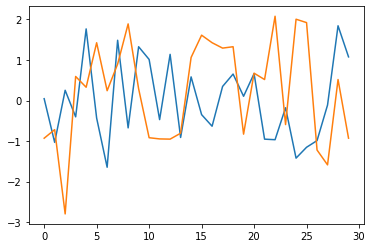

In [169]:
plt.plot(processes[rng.integers(0, M_RUNS), :30, 0])
plt.plot(processes[rng.integers(0, M_RUNS), :30, 1]);

In [21]:
def get_bootstrap_samples_lead_lag(X_raw, Y_raw):
    single_sample_length = int(N_TIMESTEPS / SIG_KERNEL_SAMPLES_NO)
        
    x_bootstrap_samples = torch.zeros(SIG_KERNEL_SAMPLES_NO, single_sample_length, 2)
    y_bootstrap_samples = torch.zeros(SIG_KERNEL_SAMPLES_NO, single_sample_length, 2)
    
    rng = np.random.default_rng(1234)
    
    for i in range(SIG_KERNEL_SAMPLES_NO):
        idx_low = rng.integers(0, N_TIMESTEPS - single_sample_length + 1)
        x_bootstrap_samples[i, :, 0] = X_raw[idx_low+1 : idx_low+single_sample_length+1]
        x_bootstrap_samples[i, :, 1] = X_raw[idx_low : idx_low+single_sample_length]
        y_bootstrap_samples[i, :, 0] = Y_raw[idx_low+1 : idx_low+single_sample_length+1]
        y_bootstrap_samples[i, :, 1] = Y_raw[idx_low : idx_low+single_sample_length]

    return x_bootstrap_samples, y_bootstrap_samples

In [171]:
for rate in EXTINCTION_RATES:#[0, 0.3, 0.8]:    
    hsic_results[rate] = []
    cov_results[rate] = []
    for run in range(5):
        processes = gen_processes.gen_ar_iid_samples_extinct_gaussian_burn_in(30, SIG_KERNEL_SAMPLES_NO, a=A, extinction_rate=rate)
        X_raw = processes[:, :, 0]
        X_lead_lag_chopped = torch.stack((X_raw[:, 1:], X_raw[:, :-1]), axis = 2)
        
        processes_p = gen_processes.gen_ar_iid_samples_extinct_gaussian_burn_in(30, SIG_KERNEL_SAMPLES_NO, a=A, extinction_rate=rate)
        Y_raw = processes_p[:, :, 0]
        Y_lead_lag_chopped = torch.stack((Y_raw[:, 1:], Y_raw[:, :-1]), axis = 2)
        
        #processes_p = gen_processes.gen_ar_iid_samples_extinct_gaussian_burn_in(30, SIG_KERNEL_SAMPLES_NO, a=0.8, extinction_rate=rate)
        #Y_raw = processes_p[:, :, 0]
        #Y_lead_lag_chopped = torch.stack((Y_raw[:, 1:], Y_raw[:, :-1]), axis = 2)

        #idy = torch.randperm(processes.shape[0])
        print(X_lead_lag_chopped.max())
        #sigkernel.hypothesis_test(processes/8, torch.stack((processes[:, :, 0], processes[idy, :, 1]), axis = 2)/8, static_kernel=  sigkernel.RBFKernel(sigma = 1))
        #sigkernel.hypothesis_test(X_lead_lag_chopped/4, Y_lead_lag_chopped/4, static_kernel = sigkernel.RBFKernel(sigma = 1), dyadic_order = 1)
        #sigkernel.hypothesis_test(X_lead_lag_chopped/8, Y_lead_lag_chopped/8, static_kernel = sigkernel.LinearKernel(), dyadic_order = 1)
        
        #hsic_test_result = hsic_independence_test.get_test_result_matrix_shuffle(X_lead_lag_chopped/PROC_DIV, Y_lead_lag_chopped/PROC_DIV, static_kernel = sigkernel.RBFKernel(sigma = RBF_SIGMA))
        #hsic_test_result = hsic_independence_test.get_test_result_matrix_shuffle(X_lead_lag_chopped/PROC_DIV, Y_lead_lag_chopped/PROC_DIV, static_kernel = sigkernel.RBFKernel(sigma = RBF_SIGMA))
        #cov_test_result = cov_independence_test.get_test_result(X, Y)
        print('RUN:', run)
        print('HSIC:', hsic_test_result[1:])
        #print('COV:', cov_test_result)

        hsic_results[rate].append(hsic_test_result)
        #cov_results[rate].append(cov_test_result)
        
    print('==================== END RATE {} ================='.format(rate))

NameError: name 'hsic_results' is not defined

In [176]:
hsic_results = {}
cov_results = {}

In [206]:
for rate in EXTINCTION_RATES:#[0, 0.3, 0.8]:    
    #processes = gen_processes.gen_ar_iid_samples_extinct_gaussian_burn_in(N_TIMESTEPS+1, M_RUNS, a=A, extinction_rate=rate)
    hsic_results[rate] = []
    cov_results[rate] = []
    for run in range(M_RUNS):
        #X_raw = processes[run, :, 0]
        #Y_raw = processes[run, :, 1]
        #X_lead_lag_chopped, Y_lead_lag_chopped = get_bootstrap_samples_lead_lag(X_raw, Y_raw)
        
        #X = X_raw[:N_TIMESTEPS]
        #Y = Y_raw[:N_TIMESTEPS]
        processes = gen_processes.gen_ar_iid_samples_extinct_gaussian_burn_in(int(N_TIMESTEPS/SIG_KERNEL_SAMPLES_NO), SIG_KERNEL_SAMPLES_NO, a=A, extinction_rate=rate)/3
        #processes = gen_processes.gen_ar_iid_samples_burn_in(int(N_TIMESTEPS/SIG_KERNEL_SAMPLES_NO), SIG_KERNEL_SAMPLES_NO, a = A, corr=rate)
        X_raw = processes[:, :, 0]
        Y_raw = processes[:, :, 1]
        X_lead_lag_chopped = torch.stack((X_raw[:, 1:], X_raw[:, :-1]), axis = 2)
        Y_lead_lag_chopped = torch.stack((Y_raw[:, 1:], Y_raw[:, :-1]), axis = 2)
        
        postscale_x = get_postscale_for_batch(X_lead_lag_chopped, sigkernel_scale.SigKernel(sigkernel_scale.LinearKernel(), 3));
        postscale_y = get_postscale_for_batch(Y_lead_lag_chopped, sigkernel_scale.SigKernel(sigkernel_scale.LinearKernel(), 3));
        
        #hsic_test_result = hsic_independence_test.get_test_result_matrix_shuffle(X_lead_lag_chopped/PROC_DIV, Y_lead_lag_chopped/PROC_DIV, static_kernel = sigkernel.RBFKernel(sigma = RBF_SIGMA))
        hsic_test_result = hsic_independence_test.get_test_result_matrix_shuffle(X_lead_lag_chopped, Y_lead_lag_chopped, static_kernel = sigkernel_scale.LinearKernel(), dyadic_order = 2, postscale_x = postscale_x, postscale_y = postscale_y)
        #cov_test_result = cov_independence_test.get_test_result(X, Y)
        print('RUN:', run)
        print('HSIC:', hsic_test_result[1:])
        #print('COV:', cov_test_result)

        hsic_results[rate].append(hsic_test_result)
        #cov_results[rate].append(cov_test_result)
        
    print('==================== END RATE {} ================='.format(rate))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.36it/s]


RUN: 0
HSIC: (0.005140802070553896, 0.5)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.28it/s]


RUN: 1
HSIC: (0.006748343120614786, 0.08)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:21<00:00,  2.33it/s]


RUN: 2
HSIC: (0.0038694106671570694, 0.84)


KeyboardInterrupt: 

In [130]:
def get_null_rejection_rate(results):
    a = 0
    for tup in results:
        a += (tup[2] < 0.025) or (tup[2] > 0.975)
    return a / len(results)

In [131]:
def get_null_sampling_approx_from_all_results(all_results):
    null_approx = None
    for rate in all_results.keys():
        for tup in all_results[rate]:
            if null_approx == None:
                null_approx = tup[0]
            else:
                null_approx = torch.cat((null_approx, tup[0]), dim = 0)
    null =  np.array([item.item() for item in null_approx])
    null.sort()
    return null

In [132]:
def get_test_statistic_dists_from_all_results(all_results):
    hsic_dist = {}
    a = 0
    for rate in all_results.keys():
        hsic_dist[rate] = []
        for tup in all_results[rate]:
            hsic_dist[rate].append(tup[1])
        hsic_dist[rate] = np.array(hsic_dist[rate])
    return hsic_dist

In [133]:
def get_cov_null_rejection_rate(results):
    a = 0
    for tup in results:
        a += (tup[1] < 0.025) or (tup[1] > 0.975)
    return a / len(results)

In [134]:
def get_test_cutoff_thresholds_for_null(null):
    return (null[int((len(null)-1)*0.025)], null[int((len(null)-1)*0.975)])

In [135]:
null = get_null_sampling_approx_from_all_results(hsic_results)
test_statistic_dists = get_test_statistic_dists_from_all_results(hsic_results)
low_thresh, high_thresh = get_test_cutoff_thresholds_for_null(null)

In [137]:
plt.scatter(EXTINCTION_RATES, [get_null_rejection_rate(hsic_results[rate]) for rate in [0.8]])
#plt.scatter(EXTINCTION_RATES, [get_cov_null_rejection_rate(cov_results[rate]) for rate in [0.3]])

KeyError: 0.8

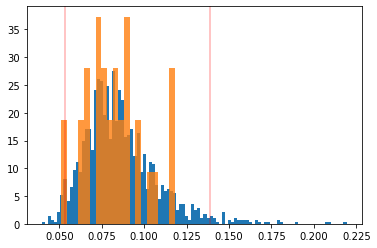

In [140]:
# RBF Bandwidth = 4, extinct gaussian
plt.hist(null, bins = 100, density = True);
plt.hist(test_statistic_dists[0.9], bins = 20, density = True, alpha = 0.8)
plt.axvline(low_thresh, alpha = 0.3, color = 'red')
plt.axvline(high_thresh, alpha = 0.3, color = 'red')

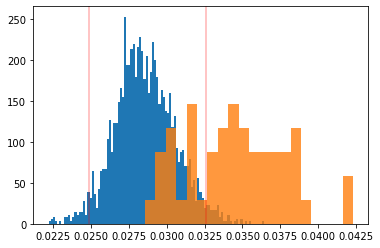

In [97]:
# RBF Bandwidth = 4
plt.hist(null, bins = 100, density = True);
plt.hist(test_statistic_dists[0.3], bins = 20, density = True, alpha = 0.8)
plt.axvline(low_thresh, alpha = 0.3, color = 'red')
plt.axvline(high_thresh, alpha = 0.3, color = 'red')

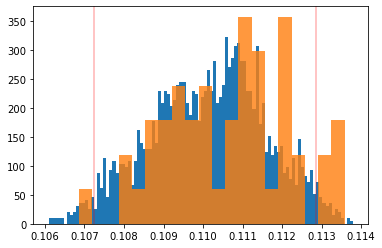

In [79]:
# RBF Bandwidth = 0.5
plt.hist(null, bins = 100, density = True);
plt.hist(test_statistic_dists[0.3], bins = 20, density = True, alpha = 0.8)
plt.axvline(low_thresh, alpha = 0.3, color = 'red')
plt.axvline(high_thresh, alpha = 0.3, color = 'red')

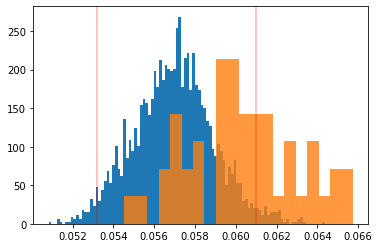

In [39]:
# RBF Bandwidth = 2
plt.hist(null, bins = 100, density = True);
plt.hist(test_statistic_dists[0.3], bins = 20, density = True, alpha = 0.8)
plt.axvline(low_thresh, alpha = 0.3, color = 'red')
plt.axvline(high_thresh, alpha = 0.3, color = 'red')

In [ ]:
def push_results():
    BIG_RESULT_MEMORY_PLACE.append({
        'N_TIMESTEPS' : N_TIMESTEPS,
        'NO_TIMESTEPS_PER_SAMPLE' : int(N_TIMESTEPS / SIG_KERNEL_SAMPLES_NO),
        'SIG_KERNEL_SAMPLES_NO' : SIG_KERNEL_SAMPLES_NO,
        'M_RUNS' : M_RUNS,
        'RBF_SIGMA' : RBF_SIGMA,
        'NULL' : null,
        'A' : A,
        'TEST DISTS' : test_statistic_dists,
        'TEST HIGH LOW THRES': (high_thresh, low_thresh),
        'COMMENT' : 'Normalized kernel, this is extinct'
    })
    pp.pprint(BIG_RESULT_MEMORY_PLACE[-1])

In [ ]:
push_results()

In [ ]:
import datetime

In [ ]:
import pickle
with open('./hsic_test_on_extinct_gaussian_BIG_RESULTS_{}.pickle'.format(datetime.datetime.today()).replace(' ', '_').replace(':', '.'), 'wb') as f:
    pickle.dump(BIG_RESULT_MEMORY_PLACE, f)

In [145]:
processes = gen_processes.gen_ar_iid_samples_extinct_gaussian_burn_in(int(N_TIMESTEPS/SIG_KERNEL_SAMPLES_NO), SIG_KERNEL_SAMPLES_NO, a=A, extinction_rate=rate)

In [146]:
processes.shape

torch.Size([300, 6, 2])

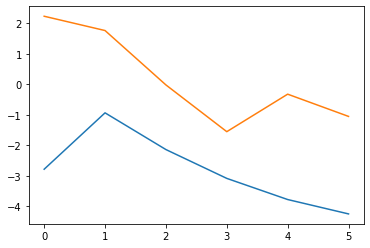

In [157]:
i = np.random.randint(0, 300)
plt.plot(processes[i, :, 0])
plt.plot(processes[i, :, 1])

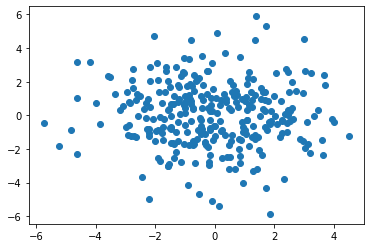

In [159]:
plt.scatter(processes[:, 1, 0], processes[:, 1, 1])

In [197]:
processes_nextinct = gen_processes.gen_ar_iid_samples_extinct_gaussian_burn_in(50, 10, a=0, extinction_rate=1)

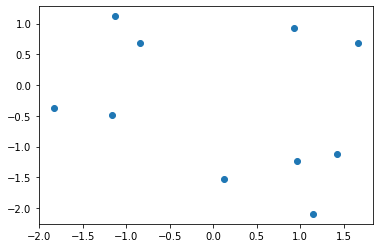

In [198]:
plt.scatter(processes_nextinct[:, 0, 0], processes_nextinct[:, 0, 1])

In [199]:
stats.ks_2samp(processes_nextinct[:, 0, 0], processes[:, 1, 0])

KstestResult(statistic=0.2, pvalue=0.7698803326880861)

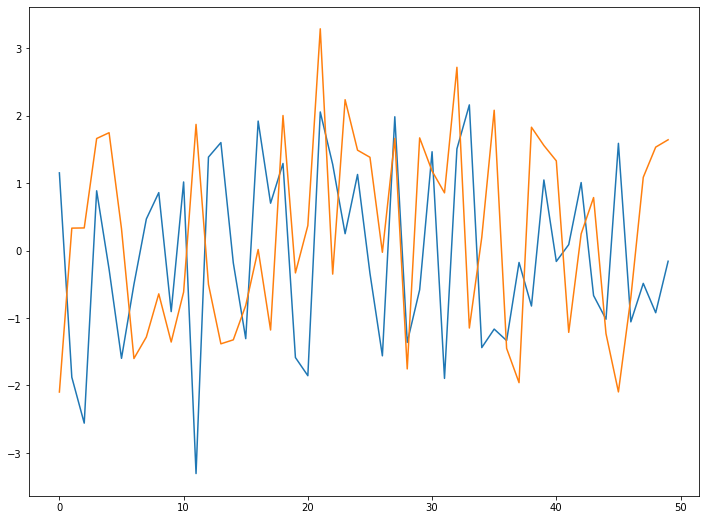

In [205]:
i = np.random.randint(0, 10)
plt.figure(figsize = (12, 9))
plt.plot(processes_nextinct[i, :, 0])
plt.plot(processes_nextinct[i, :, 1])